In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-09-22 18:20:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   202MB/s    in 0.4s    

2019-09-22 18:20:25 (202 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [0]:

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
print(last_output)

last layer output shape: (None, 7, 7, 768)
Tensor("mixed7/concat:0", shape=(?, 7, 7, 768), dtype=float32)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
import os
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zip_ref = ZipFile('/content/drive/My Drive/chest-xray-pneumonia.zip', 'r')

zip_ref.extractall('/data')
zip_ref.close()

zip_ref = ZipFile('/data/chest_xray.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()
print(os.listdir("/data"))

# Define our example directories and files
base_dir = '/data/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training PNEUMONIA pictures
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Directory with our training NORMAL pictures
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# Directory with our validation PNEUMONIA pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

# Directory with our validation NORMAL pictures
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

train_pneumonia_fnames = os.listdir(train_pneumonia_dir)
train_normal_fnames = os.listdir(train_normal_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



['__MACOSX', 'chest_xray', 'chest_xray.zip']
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2
100/100 - 192s - loss: 0.3742 - acc: 0.8395 - val_loss: 2.2877 - val_acc: 0.5000
Epoch 2/2
100/100 - 186s - loss: 0.2309 - acc: 0.9048 - val_loss: 3.5260 - val_acc: 0.5000


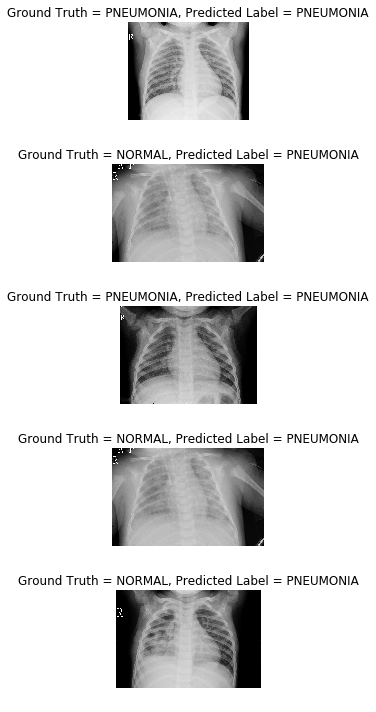

In [0]:
from random import randint
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

y = validation_generator.classes
yhat = model.predict_generator(validation_generator,
                                 steps = len(validation_generator),
                                 verbose = 0)  

label_dict = {0:"PNEUMONIA", 1:"NORMAL"}

val_file_names = validation_generator.filenames
n = len(val_file_names)

plt.rcParams["figure.figsize"] = 12, 10

for i in range(5):
    index = randint(0, n - 1)
    file_name = os.path.join(validation_dir, val_file_names[index])
    
    image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ground_truth_label = label_dict[int(y[index])]
    predicted_label = label_dict[int(yhat[index])]
    
    plt.subplot(5, 1, i + 1)
    plt.axis("off")
    plt.imshow(image)
    
    title = "Ground Truth = " + ground_truth_label + ", Predicted Label = " + predicted_label
    plt.title(title)

plt.tight_layout()
plt.show()